# Chess Computer Vision
 
As a reminder, this part of the project goal is - 

**given an image of a computer screen, identify the chess board within it, and determine the state of the game**

To simplify this problem we will devide it into two sub problems - 
1. Identify a chess board in an image. Identify each individual tile of the board as a separate image.
2. Given a tile with a chess piece, determine the identity of the chess piece.
 
## Identify a chess board in an image
There are several possible approaches to solve this problem. 
Generally this problem can also be devided into the sub-problems of identifying the bounding box for the entire box, and after we have the board we will identifying each tile. Identifying each tile is relativily easy, since all tiles are of equal size.

One possible solution is to use deep neural network which will be given a screen shots with chess boards, and return a bounding box for the chess board. 
While this is possible and might work quite well, it felt to us like using a 10-kg hammer when what we really need is a screwdriver. 
The features of a chess board are unique enough to be identifiable using finite image recognision algorithms and methods.  
Other then that, in regards to the learning value of this project, we already utilise ML and specifically deep neural networks in other parts of this projects.
So we think it will be suitable to use and image Recognision approach to solve this problem


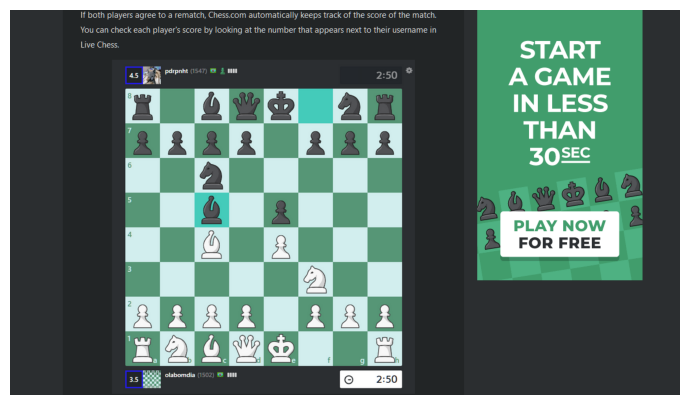

In [47]:
# We will start with our original image - 
import cv2
import imutils 
import numpy as np
import matplotlib.pyplot as plt


image = cv2.imread('res/board_webpage.png')
plt.figure(figsize=(19,12))
plt.subplot(121)
plt.imshow(image)
plt.axis('off')
plt.show()

## Preprocessing the image
The Naive approach we will attempt is to identify all suqares in the image. If we manage to find 8 squares which are right next to each other and are of the same size, then this will be our chess board. 
We know that this is probably not a perfect approach, but it will surly advance us towards a better solution.

We want our algorithm to be able to handle different boards and different backgrounds.
All we care about is the shapes in the image so we will try to find the contuors in the image. 



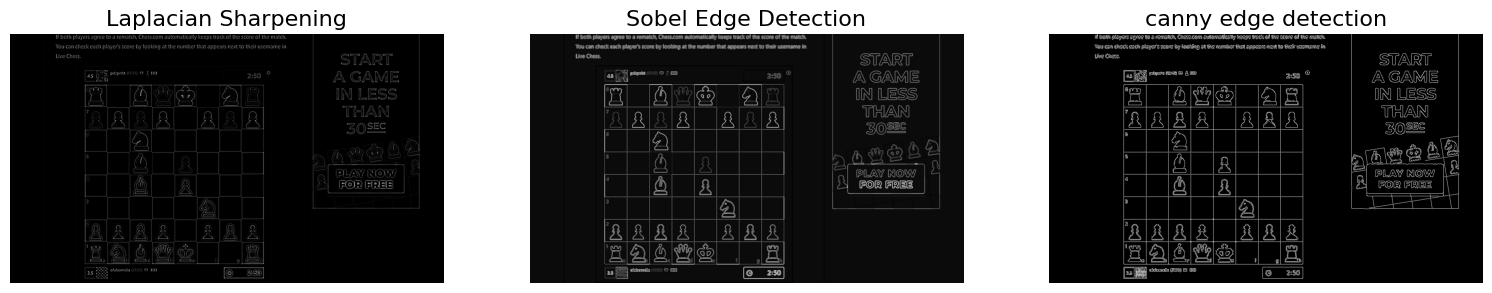

In [48]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# Try several different edge detection methods - 
# 1. Laplacian of gaussian - Gaussian blur + Laplacian edge detection (gonzalsez and woods, image processing course book)
l_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
img_sharp_laplac = cv2.filter2D(blurred, -1, l_kernel)

# 2. Sobel Edge detection - https://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm
# The concept is similar to laplactian, in the fact that we want to find a gradient in the image,
# The strength of the sobel operator comes from taking the derivative of the image in the x and y direction, instead of just looking at overall difference like the laplacian
sobel_y_kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
sobel_x_kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
img_sharp_sobel_x = np.absolute(cv2.filter2D(gray, cv2.CV_64F, sobel_x_kernel))
img_sharp_sobel_y = np.absolute(cv2.filter2D(gray, cv2.CV_64F, sobel_y_kernel))

magnitude = np.sqrt(img_sharp_sobel_x**2 + img_sharp_sobel_y**2)
bias_correction = np.mean(magnitude)
corrected_magnitude_sobel = np.abs(magnitude - bias_correction)

# Normalize to 0-255 range
corrected_magnitude_sobel = np.uint8(255 * corrected_magnitude_sobel / np.max(corrected_magnitude_sobel))

# image_sobel = cv2.addWeighted(img_sharp_sobel_x, 0.5, img_sharp_sobel_y, 0.5, 0)
# 3. Canny edge detection -  https://www.youtube.com/watch?v=sRFM5IEqR2w&ab_channel=Computerphile
'''
 Essentially takes the output of a sobel operator and does some cleaning up.
        a. thins the edges
        We do this by finding local maximum of the edge in a mask, eliminating what is not the local maximum. this way we only keep the
        edge pixels on the "direction" of the edge
        b. does a 2-level thresholding (hysteresis) -
            i. Set two thresholds - high and low.
            ii. If the pixel is above the high threshold, it will be automaticvally included
            iii. If the pixel is below the low threshold, it will be automatically excluded
            iv. If the pixel is between the two thresholds, it will be included only if it is connected to a pixel above the high threshold
'''
t_lower = 60  # Lower Threshold 
t_upper = 200  # Upper threshold 
aperture_size = 3  # Aperture size 

img_canny = cv2.Canny(gray, t_lower, t_upper,  
            apertureSize=aperture_size, L2gradient =True) 

plt.figure(figsize=(19,12))
plt.subplot(131)
plt.imshow(img_sharp_laplac, cmap='gray')
plt.title('Laplacian Sharpening', fontsize=16)
plt.axis('off')
plt.subplot(132)
plt.imshow(corrected_magnitude_sobel, cmap='gray')
plt.title('Sobel Edge Detection', fontsize=16)
plt.axis('off')
plt.subplot(133)
plt.imshow(img_canny, cmap='gray')
plt.title('canny edge detection', fontsize=16)
plt.axis('off')
plt.show()

Using the Canny Edge detection technique we get a good and sharp representation of the contures in the image.
Now in order to detect squares, we will use  **morphological filtering**.
The concept of morphological filtering is to identify certain partterns or shapes in an image, and transforming them in some way.

We can use morphological filtering to detect patterns in the image. We can attempt to identify the square itself, but we do not know it's size so it will be quite hard.  Instead we can attempt to identify square corners, and from there construct our square.
We have attempted to implement this approach, but run into some obstacles -
1. the corner detection yileds alot of false posibtives (corners which are not part of a square)
2. the process of grouping corners into squares is not trivial. especially in the case of a chess board, where infact one can look at the board as seperate squares, or as squares which are contained within eachother in growing size.

While both problems are algorithmically solvable, we have devised a better way to use morphological filtering to solve our chess problem.
Another pattern that appers in a chess board is the cross - 


In [49]:
small_kernel_size = 3
large_kernel_size = small_kernel_size*4
kernel_cross = cv2.getStructuringElement(cv2.MORPH_CROSS,(large_kernel_size,large_kernel_size))
print(kernel_cross)

[[0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]]


In every intersection of 4 tiles in the edge image there should be a cross. We can attempt to identify them in the following way - 


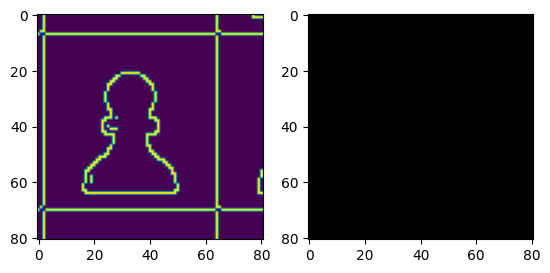

In [50]:
def display_subimages(s, img1, img2):
    i,j,l = s
    sub1 = img1[i:i+l+1, j:j+l+1]
    sub2 = img2[i:i+l+1, j:j+l+1]
    plt.subplot(121)
    plt.imshow(sub1)
    plt.subplot(122)
    plt.imshow(sub2, cmap='gray')
    plt.show()
img_hms = cv2.morphologyEx(img_canny, cv2.MORPH_HITMISS, kernel_cross)
display_subimages((200, 270, 80), img_canny, img_hms)


Well... this didn't work so well.
If we examine the canny image more carefully, we can notice some small inaccuracies which might cause this affect - 


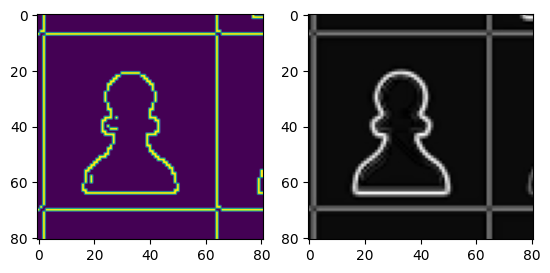

In [51]:

display_subimages((200, 270, 80), img_canny, corrected_magnitude_sobel)

We see That in all of our edge detection methods there is some uncertainty in the intersections, so the crosses are not found in the image.
This might be solvable by using the "Closure" morphological filter, but using "Closure" might cause some unwanted side affects (such as corner dielation).
A simpler solution is to alter our cross filter to not require an exact match at the center of the cross 

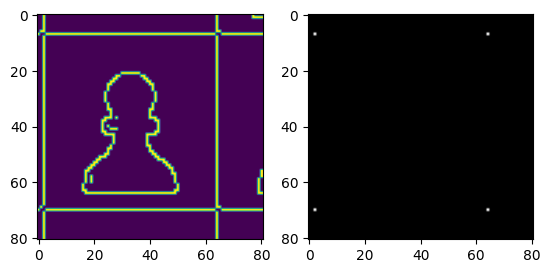

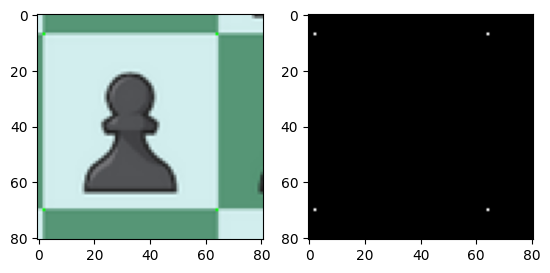

In [52]:
def draw_on_image(mask_img, original_image, color):
    # for every pixel which is not zero in the mask_image, draw a point in the original image - 
    new_image = original_image.copy()
    new_image[np.nonzero(mask_img)] = color
    return new_image


kernel_cross[large_kernel_size//2 - small_kernel_size//2: large_kernel_size//2 + small_kernel_size//2+1,
                  large_kernel_size//2 - small_kernel_size//2: large_kernel_size//2 + small_kernel_size//2+1] = 0 
img_hms = cv2.morphologyEx(img_canny, cv2.MORPH_HITMISS, kernel_cross)
display_subimages((200, 270, 80), img_canny, img_hms)

crossed_image = draw_on_image(img_hms, image, (0, 255, 0)) # green
# display_subimages((200, 270, 80), img_canny, img_hms)
display_subimages((200, 270, 80), crossed_image, img_hms)


Now that we've identified our crosses, we want to look for a pattern of a chess board - which means finding 7 sets of crosses in a row and in a line.
We do it by sorting the found crosses by y and then by x, then traversing the found crosses to see if we have 7 consecutive crosses which are evenly spread (in the same distance from one another)

In [53]:


class Cross(object):
    def __init__(self, i, j):
        self.row = i
        self.col = j
    def __str__(self) -> str:
        return f"({self.row}, {self.col})"
    def __repr__(self) -> str:
        return f"({self.row}, {self.col})"
def find_even_spread_dots(arr, dist_mistake, num_dots=7):
    # assume array is sorted 
    for i in range(0, len(arr)-(num_dots-1)):
            distances = [arr[j+1] - arr[j] for j in range(i, i+num_dots-1)]
            if max(distances) - min(distances) > dist_mistake: 
                continue
            suspected_square_delim = sum(distances)//len(distances)
            yield i, suspected_square_delim

def verify_even_spread_dots(arr, dist_mistake, suspected_square_delim):
    distances = [arr[j+1] - arr[j] for j in range(0, len(arr)-1)]
    if max(distances) - min(distances) > dist_mistake: 
        return False
    if sum(distances)//len(distances) < suspected_square_delim+ dist_mistake and sum(distances)//len(distances) > suspected_square_delim - dist_mistake:
        return True
    return False

In [54]:

def detect_chess_board(img, original_image):
    '''
    receive a canny image. my target is to find the crosses which are created when 4 squares of the chess board are connected.
    sometimes the crosses are not well connected in the canny image, so the approach is to use Hit-And-Miss morphological operation
    to find the crosses, but to also allow for errors in the middle of the crosses.

    After doing hit-and-miss, search for 7 consecutive crosses in a row, and then search for 7 consecutive crosses in a column.
    Try to find in this fashion the cross at the top left corner of the board and the delimiter of a square in the chess board. 
    '''

    # Step 1 - do Hit-And-Miss morphological operation to find the crosses
    small_kernel_size = 3
    large_kernel_size = small_kernel_size*4
    kernel_cross = cv2.getStructuringElement(cv2.MORPH_CROSS,(large_kernel_size,large_kernel_size))
    # make the center un-crossed
    kernel_cross[large_kernel_size//2 - small_kernel_size//2: large_kernel_size//2 + small_kernel_size//2+1,
                  large_kernel_size//2 - small_kernel_size//2: large_kernel_size//2 + small_kernel_size//2+1] = 0 
    img_hms = cv2.morphologyEx(img, cv2.MORPH_HITMISS, kernel_cross)
    original_image = draw_on_image(img_hms, original_image, (0, 255, 0)) # green

    # Step 2 - in the hms image, search for aligned crosses.
    crosses = [Cross(i,j) for i,j in np.argwhere(img_hms)]
    crosses_by_row = {i: [] for i in range(img_hms.shape[0])}
    crosses_by_col = {j: [] for j in range(img_hms.shape[1])}
    for c in crosses:
        
        # they should be sorted
        crosses_by_row[c.row].append(c)
        crosses_by_col[c.col].append(c)

    # for every cross, search for a cross in the same row and column.
    # chess is 8x8
    # i should have 7x7 of crosses in the board.
    found = False
    suspected_square_delim = 0
    top_cross = None
    for row in sorted(crosses_by_row.keys()):
        r = 1 # search in r rows below and r rows above, to allow some mistakes
        dist_mistake = 1 # allow mistake in distance between crosses
        corsses_in_row = crosses_by_row[row]
        for i in range(1, r+1):
            if row-i in crosses_by_row:
                corsses_in_row += crosses_by_row[row-i]
            if row+i in crosses_by_row:
                corsses_in_row += crosses_by_row[row+i]

        
        if len(corsses_in_row) < 7:
            continue
    
        # now i need to verify that i have 7 crosses that are spaced evenly.
        # i will sort them and then check that the difference between each two is the same.
        sorted_c_in_row = sorted(corsses_in_row, key= lambda c: c.col)
        for i, suspected_square_delim in find_even_spread_dots([c.col for c in sorted_c_in_row], dist_mistake, num_dots=7):
            
            # got a suspected starting cross, now check if the columns of it match
            suspected_cross = sorted_c_in_row[i]
            suspected_col = suspected_cross.col
            print(f"[+] found a suspected starting cross - ", {suspected_cross, suspected_square_delim})
            
            corsses_in_col = crosses_by_col[suspected_col]
            for k in range(1, r+1):
                if suspected_col-k in crosses_by_col:
                    corsses_in_col += crosses_by_col[suspected_col-k]
                if suspected_col+k in crosses_by_col:
                    corsses_in_col += crosses_by_col[suspected_col+k]

            if len(corsses_in_col) < 7:
                continue
            # sort the rows in the suspected colum
            sorted_c_in_col = sorted(corsses_in_col,  key= lambda c: c.row)
            initial_pos = sorted_c_in_col.index(suspected_cross)
            rows_to_check = [c.row for c in sorted_c_in_col[initial_pos:initial_pos+7]]
            
            if verify_even_spread_dots(rows_to_check, dist_mistake, suspected_square_delim):
                # TODO: i can even verify that each row and column now have good alignment, but i think it is not needed.  
                # I can also make this more robust to try to find the board even in case of some missing crosses.
                found = True
                top_cross = suspected_cross
                break
        if found:
            break
    
    if not found:
        print("did not find a chess board")
        return None

    # I need +1 here to capture the border of the tile.
    suspected_square_delim +=1
    # i've found a chess board - let's return the bounding box (upper left, lower right) and square delimiter of the board
    top_left = (top_cross.row - suspected_square_delim, top_cross.col - suspected_square_delim)
    bottom_right = (top_cross.row + 7*suspected_square_delim, top_cross.col + 7*suspected_square_delim)
    return (top_left, bottom_right, suspected_square_delim)

In [55]:
(top_left, bottom_right, delim) = detect_chess_board(img_canny, image)
print(f"[+] Found chess board - top left: {top_left}, bottom right: {bottom_right}, delim: {delim}")

[+] found a suspected starting cross -  {(207, 272), 62}
[+] Found chess board - top left: (144, 209), bottom right: (648, 713), delim: 63


Let's write some code to visualize our findings - 

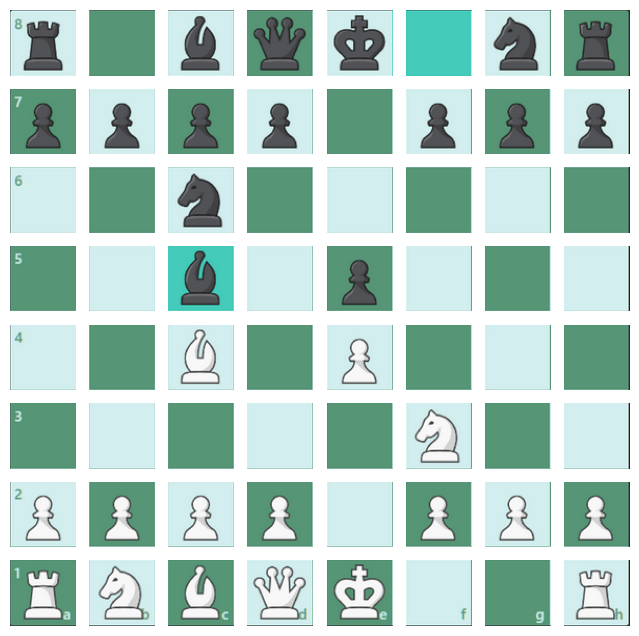

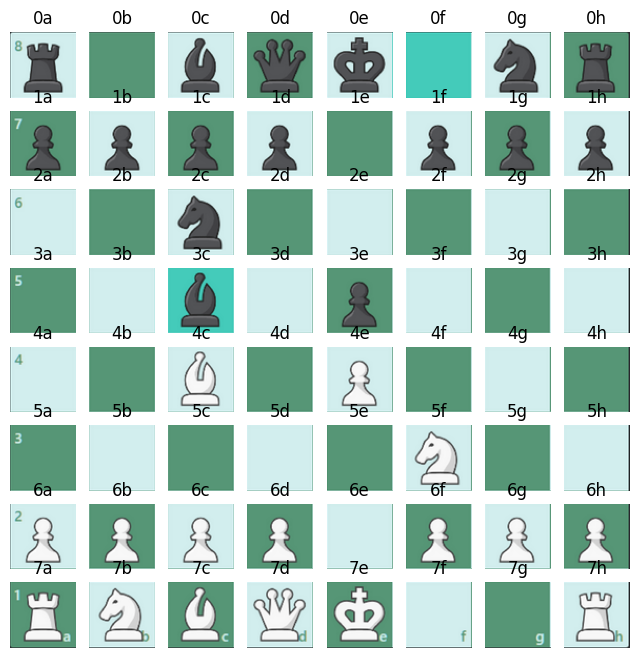

: 

In [59]:
def split_chess_board(image, top_left, bottom_right, delim):
    chess_board_squares = []
    for i in range(8):
        row = []
        for j in range(8):
            row.append(image[top_left[0] + i*delim: top_left[0] + (i+1)*delim, top_left[1] + j*delim: top_left[1] + (j+1)*delim].copy())
        chess_board_squares.append(row)
    return chess_board_squares
def display_board_image(chess_board_squares, labels=None):
    fig = plt.figure(figsize=(8, 8))    
    for i in range(8):
        for j in range(8):
            ax = fig.add_subplot(8, 8, i*8+j+1)
            if labels is not None:
                ax.set_title(labels[i*8 + j])
            ax.imshow(chess_board_squares[i][j])
            ax.axis('off')
    plt.show()

splitted_board = split_chess_board(image, top_left, bottom_right, delim)
display_board_image(splitted_board)
display_board_image(splitted_board, labels=[f"{i}{chr(ord('a')+j)}" for i in range(8) for j in range(8)])

## Conclusion - Identifing a chess board in an image

We've succesfully identified our board and splitted it into pices. Now for our next part - classifing the tiles.
In the future, if need be, this identification method can become more rubust by relaxing the constraints on cross placement while intrudcing more sanity checks (e.g. allow for looser fits or the crosses on the screen).
We can now move on to the next part - classifying chess pieces!





## Classification of chess tiles
This is a classic classification problems, for which there are many common ML models and approaches.
We decided to use a supervised classification approach, using data of different chess pieces and their label.

In this notebook we explore different ML approaches and different alterations of the dataset, and see how we can reach a model with the highest accuracy. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
import os
from fastcore.all import *
import matplotlib.pyplot as plt
import itertools

# from fastai.data.all import *
# from fastai.vision.all import *
# from fastai.vision.all import *
import cv2
from PIL import Image
import pathlib

## Choosing a dataset
We have found two possible datasets which we can use for classification training. 
The first dataset contains a combination of painted and real world images of chess pieces.
The second dataset contains only computer-animated images of chess pieces.

Let's take a look at the dataset - 


In [3]:
def get_images_for_subpath(data_dir, subpath):
    image_paths = list(pathlib.Path(os.path.join(data_dir, subpath)).glob('*.jpg')) + list(pathlib.Path(os.path.join(data_dir, subpath)).glob('*.png'))
    # image_paths = pathlib.Path(os.path.join(data_dir, subpath)).glob('*.png')
    return [str(i) for i in image_paths]
    # print(f"number of images in {os.path.join(data_dir, subpath)}: {len(list(image_paths))}")
    # return np.array([Image.open(p) for p in image_paths])

def display_df(df):
    # print one image per label
    one_item_per_label_sample = df.groupby('label').sample(n=1).reset_index(drop=True)
    images = [Image.open(p) for p in one_item_per_label_sample['image']]
    print(images)
    fig, axes = plt.subplots(1, len(images), figsize=(5*len(images), 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(one_item_per_label_sample['label'][i])
    plt.show()

                                               image   label
0  pices_db\data_real\bishop_resized_224\00000000...  bishop
1  pices_db\data_real\bishop_resized_224\00000002...  bishop
2  pices_db\data_real\bishop_resized_224\00000003...  bishop
3  pices_db\data_real\bishop_resized_224\00000004...  bishop
4  pices_db\data_real\bishop_resized_224\00000005...  bishop
5  pices_db\data_real\bishop_resized_224\00000006...  bishop
6  pices_db\data_real\bishop_resized_224\00000008...  bishop
7  pices_db\data_real\bishop_resized_224\00000009...  bishop
8  pices_db\data_real\bishop_resized_224\00000010...  bishop
9  pices_db\data_real\bishop_resized_224\00000013...  bishop
[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x2DA5A1F98D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x2DA7374A190>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x2DA647EDAD0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x2DA647EDD10>, 

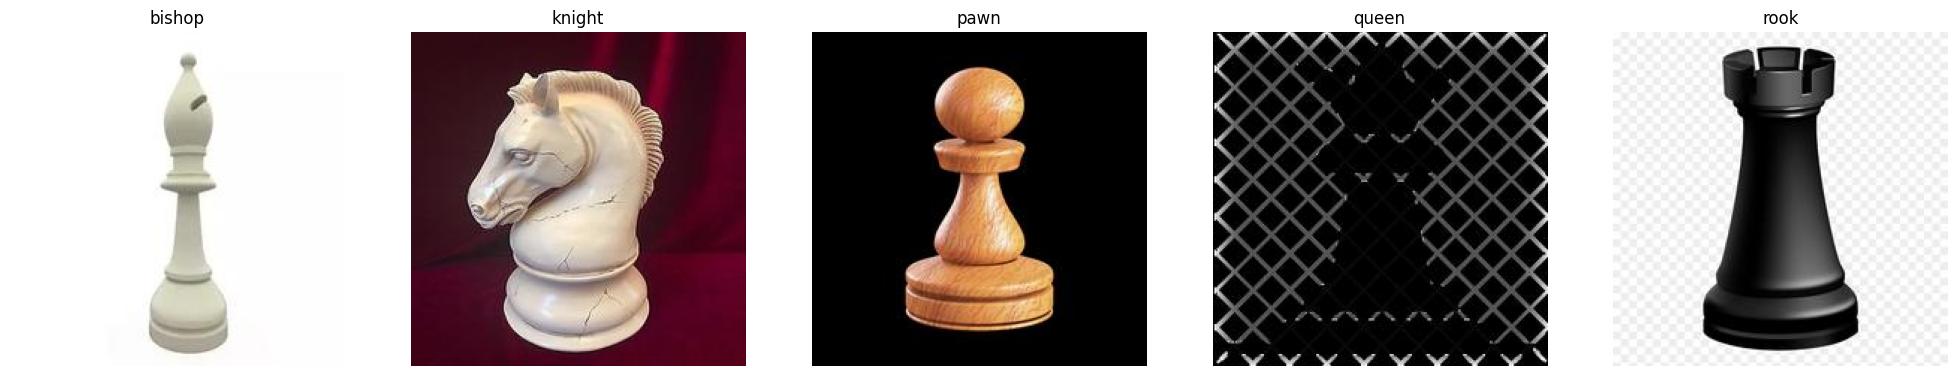

In [4]:
data_dir = "pices_db/data_real"


# bishop_images = get_images_for_subpath("bishop_resized")
# knight_images = get_images_for_subpath("knight_resized")
# pawn_images = get_images_for_subpath("pawn_resized")
# queen_images = get_images_for_subpath("queen_resized")
# rook_images = get_images_for_subpath("rook_resized")

bishop_images = get_images_for_subpath(data_dir, "bishop_resized_224")
knight_images = get_images_for_subpath(data_dir, "knight_resized_244")
pawn_images = get_images_for_subpath(data_dir, "pawn_resized_224")
# king_images = get_images_for_subpath("king")
queen_images = get_images_for_subpath(data_dir, "queen_resized_224")
rook_images = get_images_for_subpath(data_dir, "rook_resized_224")

# create a dataframe with the images and their labels
df_first = pd.DataFrame({'image': np.concatenate([bishop_images, knight_images, pawn_images, queen_images, rook_images]),
                   'label': ['bishop']*len(bishop_images) + ['knight']*len(knight_images) + ['pawn']*len(pawn_images) + ['queen']*len(queen_images) + ['rook']*len(rook_images)})
print(df_first.head(10))
display_df(df_first)

Let's also look at the distribution of the different pieces in the data - 

label
knight    169
bishop    138
rook      137
queen     111
pawn       80
Name: count, dtype: int64


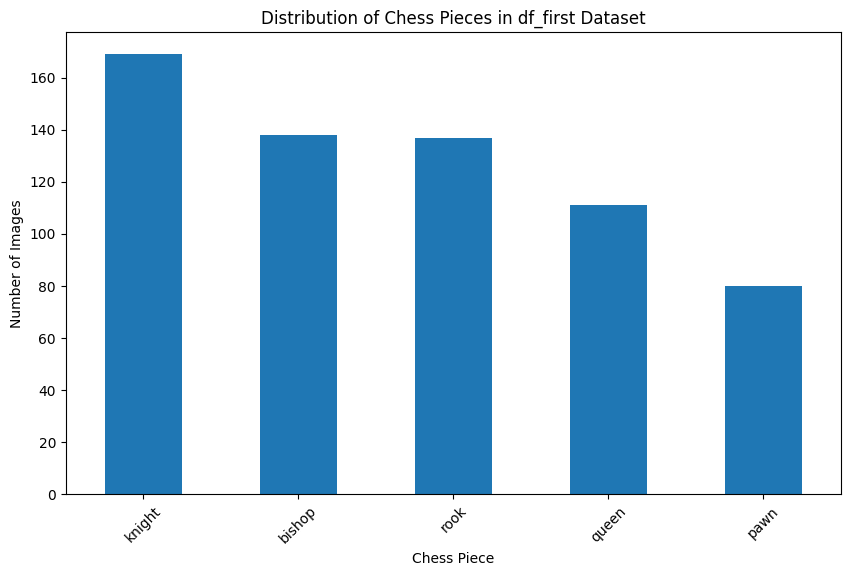

In [5]:
# Count the number of images for each chess piece
piece_counts = df_first['label'].value_counts()
print(piece_counts)
# Plot the distribution
plt.figure(figsize=(10, 6))
piece_counts.plot(kind='bar')
plt.title('Distribution of Chess Pieces in df_first Dataset')
plt.xlabel('Chess Piece')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

The first thing we notice is that there are no pieces of kings in this dataset.

Another oddity is that  the distribution is not even, as there are twice more knights than pawns. Depending on the model we pick, this might affect the result and create a bias towards knights. We can deal with it by "balancing out" the dataset.

Before we do that, we can notice that some of the images in the dataset does not match our use case - that is they are 3d images, or even real images of chess pieces.
Our usage is much simpler and is limited to 2d icon-like representation.

For these reasons we want to look for another DB with better representations.

                                image   label
0  pices_db\data_icons\bishop\100.png  bishop
1  pices_db\data_icons\bishop\101.png  bishop
2   pices_db\data_icons\bishop\34.png  bishop
3   pices_db\data_icons\bishop\35.png  bishop
4   pices_db\data_icons\bishop\36.png  bishop
5   pices_db\data_icons\bishop\37.png  bishop
6   pices_db\data_icons\bishop\38.png  bishop
7   pices_db\data_icons\bishop\39.png  bishop
8   pices_db\data_icons\bishop\40.png  bishop
9   pices_db\data_icons\bishop\41.png  bishop
[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=85x85 at 0x2DA73A0BA90>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=85x85 at 0x2DA76729550>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=85x85 at 0x2DA76765ED0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=85x85 at 0x2DA64822190>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=85x85 at 0x2DA7425E610>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=85x85 at 0x2DA7426B710>]


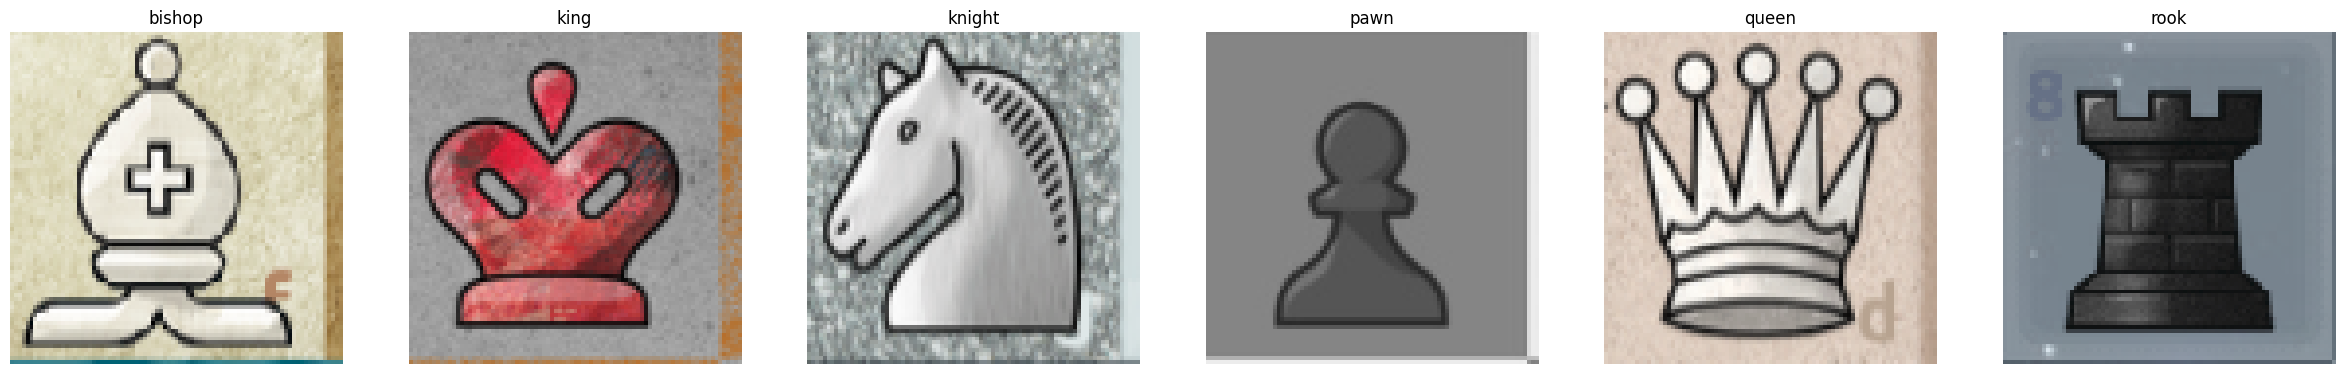

In [6]:
data_dir = "pices_db/data_icons"


bishop_images = get_images_for_subpath(data_dir, "bishop")
knight_images = get_images_for_subpath(data_dir, "knight")
pawn_images = get_images_for_subpath(data_dir, "pawn")
king_images = get_images_for_subpath(data_dir, "king")
queen_images = get_images_for_subpath(data_dir, "queen")
rook_images = get_images_for_subpath(data_dir, "rook")

# create a dataframe with the images and their labels
df = pd.DataFrame({'image': np.concatenate([bishop_images, knight_images, pawn_images, king_images, queen_images, rook_images]),
                   'label': ['bishop']*len(bishop_images) + ['knight']*len(knight_images) + ['pawn']*len(pawn_images) + ['king']*len(king_images) + ['queen']*len(queen_images) + ['rook']*len(rook_images)})
print(df.head(10))
display_df(df)

This dataset matches our needs better, as the images are in fact icons of chess pieces.
Let's analyze the distribution of this dataset. 

label
pawn      239
rook       72
knight     71
bishop     67
king       34
queen      34
Name: count, dtype: int64


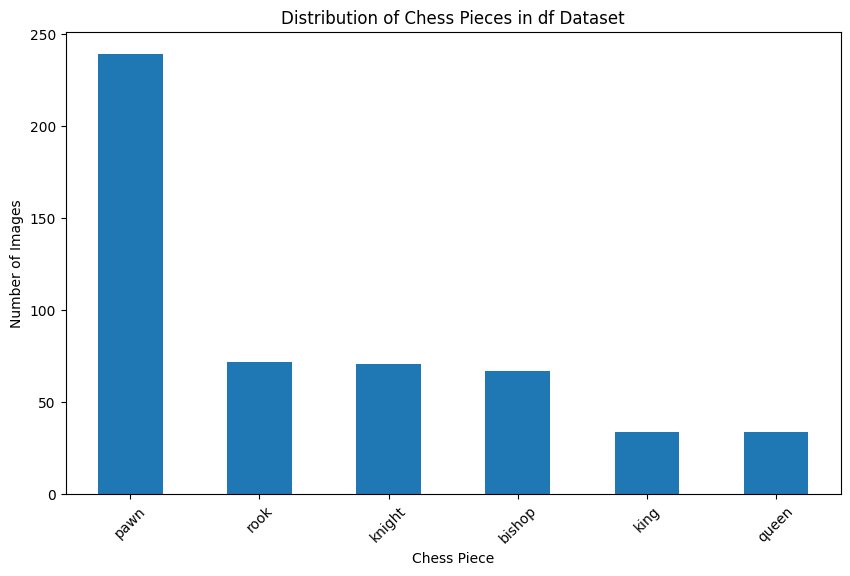

In [7]:
# Count the number of images for each chess piece
piece_counts = df['label'].value_counts()
print(piece_counts)
# Plot the distribution
plt.figure(figsize=(10, 6))
piece_counts.plot(kind='bar')
plt.title('Distribution of Chess Pieces in df Dataset')
plt.xlabel('Chess Piece')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

We see that the distribution here is not even, but this is in fact a good thing - as the distribution corresponds to the amount of pieces of each type.
E.g, there are twice as many bishops than there are kings, as there are 4 bishops in a game and only 2 kings.
the same goes for the ratio of pawns to bishops, and so on.   

let's split the data into train and test, and try to apply a simple supervised SVM classification model 

In [8]:
df.to_csv('pices_db/mainframe.csv', index=False)

In [9]:
from sklearn.model_selection import train_test_split
# get 0.8 of each label for training and 0.2 for validation
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(train.head(10))
print(test.head(10))


                                  image   label
210    pices_db\data_icons\pawn\278.png    pawn
108  pices_db\data_icons\knight\486.png  knight
340    pices_db\data_icons\pawn\408.png    pawn
87   pices_db\data_icons\knight\465.png  knight
24    pices_db\data_icons\bishop\56.png  bishop
493    pices_db\data_icons\rook\150.png    rook
348    pices_db\data_icons\pawn\416.png    pawn
76   pices_db\data_icons\knight\454.png  knight
242    pices_db\data_icons\pawn\310.png    pawn
360    pices_db\data_icons\pawn\428.png    pawn
                                  image   label
266    pices_db\data_icons\pawn\334.png    pawn
149    pices_db\data_icons\pawn\218.png    pawn
346    pices_db\data_icons\pawn\414.png    pawn
136  pices_db\data_icons\knight\515.png  knight
480    pices_db\data_icons\rook\137.png    rook
258    pices_db\data_icons\pawn\326.png    pawn
323    pices_db\data_icons\pawn\391.png    pawn
297    pices_db\data_icons\pawn\365.png    pawn
362    pices_db\data_icons\pawn\430.png 

In [10]:
def count_labels(df):
    return df['label'].value_counts()
count_labels(train), count_labels(test)

(label
 pawn      191
 knight     57
 rook       57
 bishop     54
 queen      27
 king       27
 Name: count, dtype: int64,
 label
 pawn      48
 rook      15
 knight    14
 bishop    13
 king       7
 queen      7
 Name: count, dtype: int64)

In [11]:
def get_images(image_paths):
    return np.array([Image.open(p) for p in image_paths])

x_train = get_images(train['image'])
y_train = np.array(train['label'])
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = get_images(test['image'])
y_test = np.array(test['label'])
x_test = x_test.reshape(x_test.shape[0], -1)


In [12]:

def do_svm(x_train, y_train, x_test, y_test): 
    model = SVC(kernel='linear', C=1E9)
    print("[+] training model")
    model.fit(x_train,y_train)
    print("[+] testing model")
    result = model.predict(x_test)
    mask = result==y_test
    correct = np.count_nonzero(mask)
    print (correct*100.0/result.size)
    return model

model_1 = do_svm(x_train, y_train, x_test, y_test)


[+] training model
[+] testing model
83.65384615384616


We see that a naive applience of SVM provides decent results, at 83%. 
Let's try and see if we can find some distinction between the correctly and incorrectly classified images in the test batch.

In [55]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Define the labels
def analyze_results(results_df, y_test, labels, morph=None):
    # Display two rows of images and their labels from the test set
    # One with images that were classified correctly and one with images that were classified incorrectly
    correct_images = results_df[results_df['correct']].sample(n=5)
    if len(results_df[~results_df['correct']]) < 5:
        incorrect_images = results_df[~results_df['correct']]
    else:
        incorrect_images = results_df[~results_df['correct']].sample(n=5)

    def display_images(images_df, title):
        fig, axes = plt.subplots(1, len(images_df), figsize=(5 * len(images_df), 5))
        fig.suptitle(title, fontsize=16)
        for i, ax in enumerate(axes):
            img = Image.open(images_df.iloc[i]['image'])
            if morph is not None:
                img = morph(img)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f"True: {images_df.iloc[i]['label']}\nPred: {images_df.iloc[i]['predicted_label']}")
        plt.show()

    display_images(correct_images, "Correctly Classified Images")
    display_images(incorrect_images, "Incorrectly Classified Images")

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, results_df['predicted_label'], labels=labels)

    # Convert confusion matrix to percentages
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

    # Create a DataFrame for better visualization
    conf_matrix_df = pd.DataFrame(conf_matrix_percentage, index=labels, columns=labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_df, annot=True, fmt=".2f", cmap="Blues", cbar=True)
    plt.title('Confusion Matrix - Percentage of Images Predicted as Each Label')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

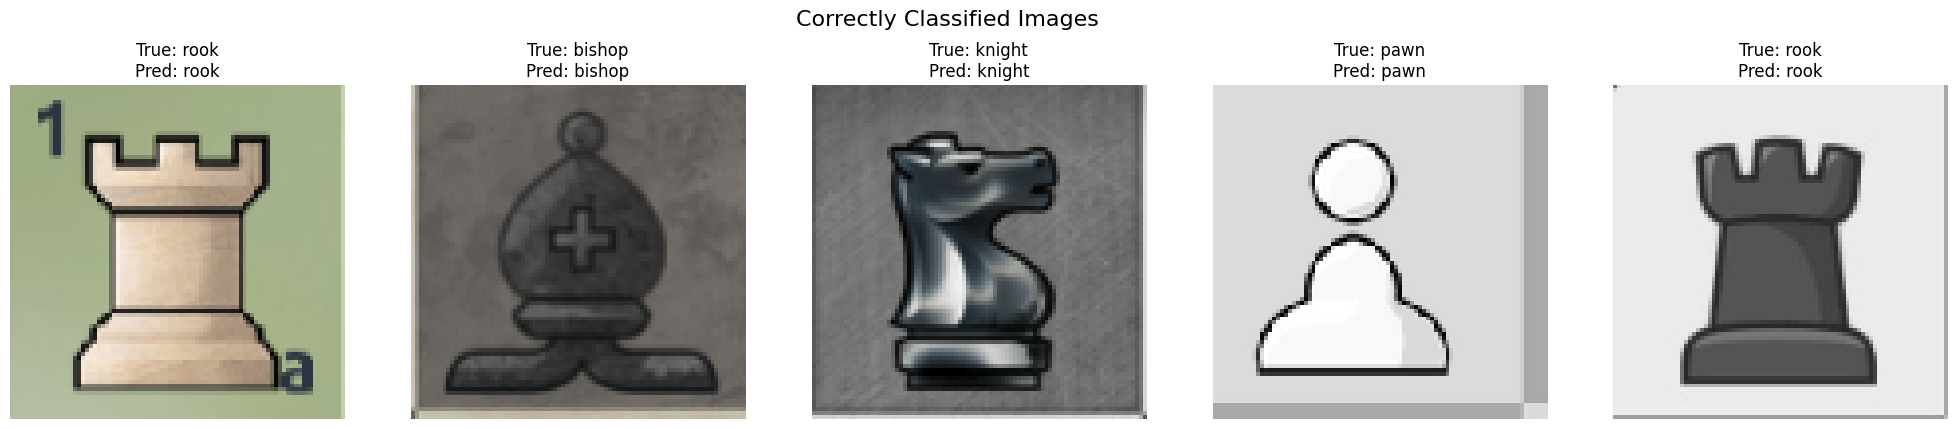

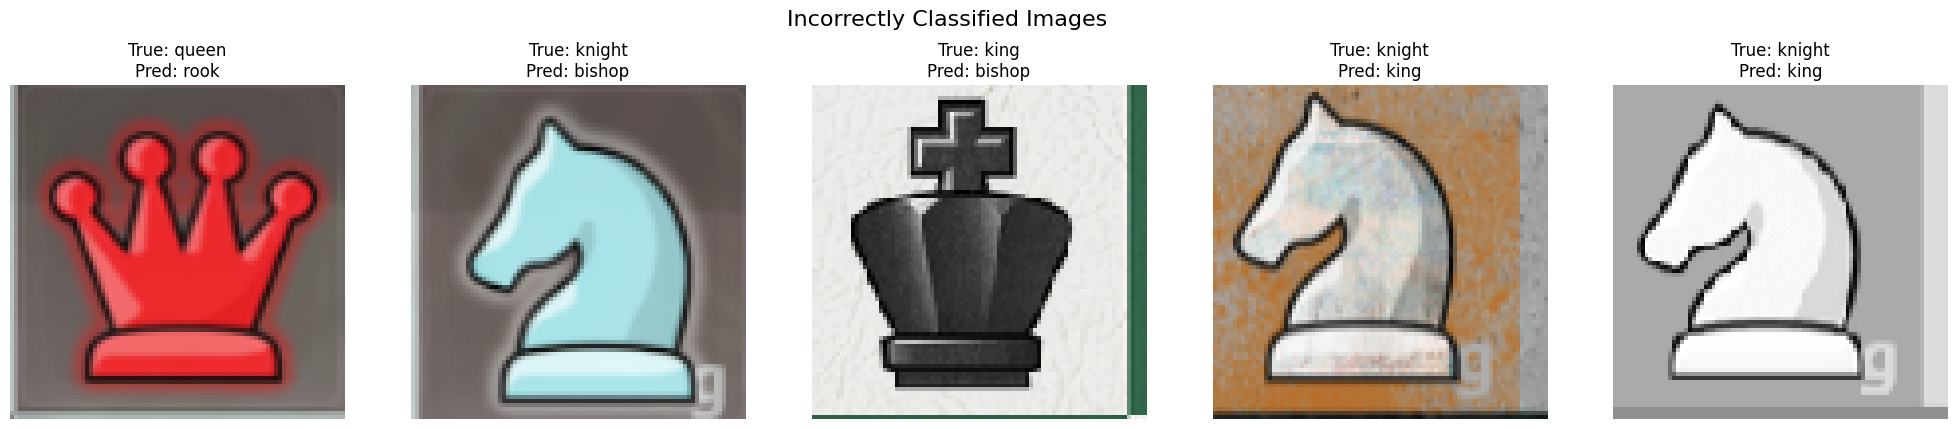

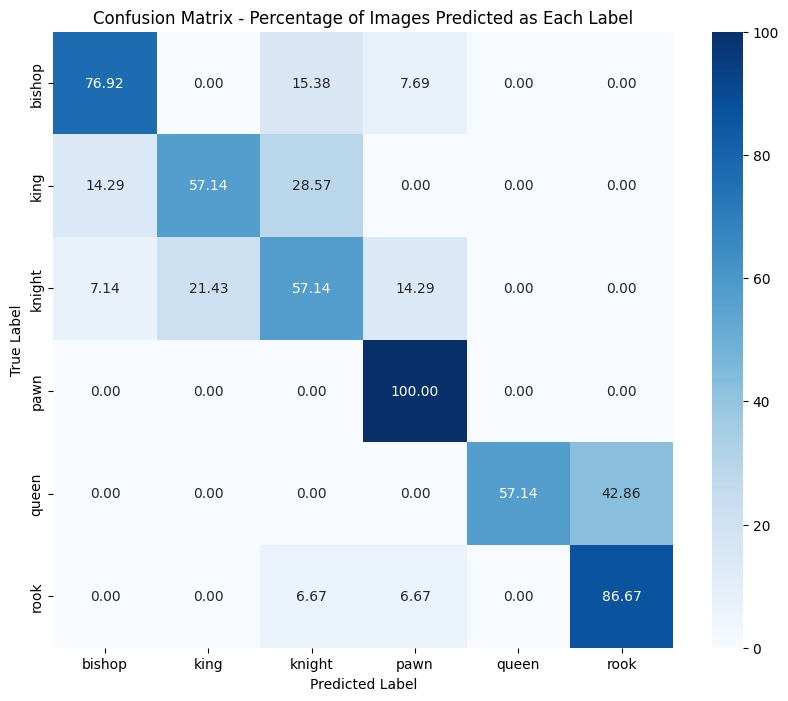

In [41]:

# Predict the labels for the test set
y_pred = model_1.predict(x_test)

# Create a DataFrame to store the results
results_df = test.copy()
results_df['predicted_label'] = y_pred
results_df['correct'] = results_df['label'] == results_df['predicted_label']
labels = np.unique(y_test)

analyze_results(results_df, y_test, labels)

We can indeed reach two interesting conclusions from this data - 
1. It seems that some of the wrongly classified images are with color, so maybe this exsessive data harms the classification.
2. it seems that some classes of pieces are classified way better, and even in some way "stronger" - for example, queen is often confused with rook but rook is almost never confused with queen

We will start by addressing the first conclusion - let's try to eliminate the color and background components. 
To remove these features, we will try to provide the model with a HOG representation of the image, which will eliminate the color and background features. 

In [32]:
def get_images_gs(image_paths):
    return np.array([cv2.imread(p,  cv2.IMREAD_GRAYSCALE) for p in image_paths])

x_train_gs = get_images_gs(train['image'])
y_train_gs = np.array(train['label'])
x_train_gs = x_train_gs.reshape(x_train_gs.shape[0], -1)
x_test_gs_im = get_images_gs(test['image'])
y_test_gs = np.array(test['label'])
x_test_gs = x_test_gs_im.reshape(x_test_gs_im.shape[0], -1)
model_gs = do_svm(x_train_gs, y_train_gs, x_test_gs, y_test_gs)


[+] training model
[+] testing model
83.65384615384616


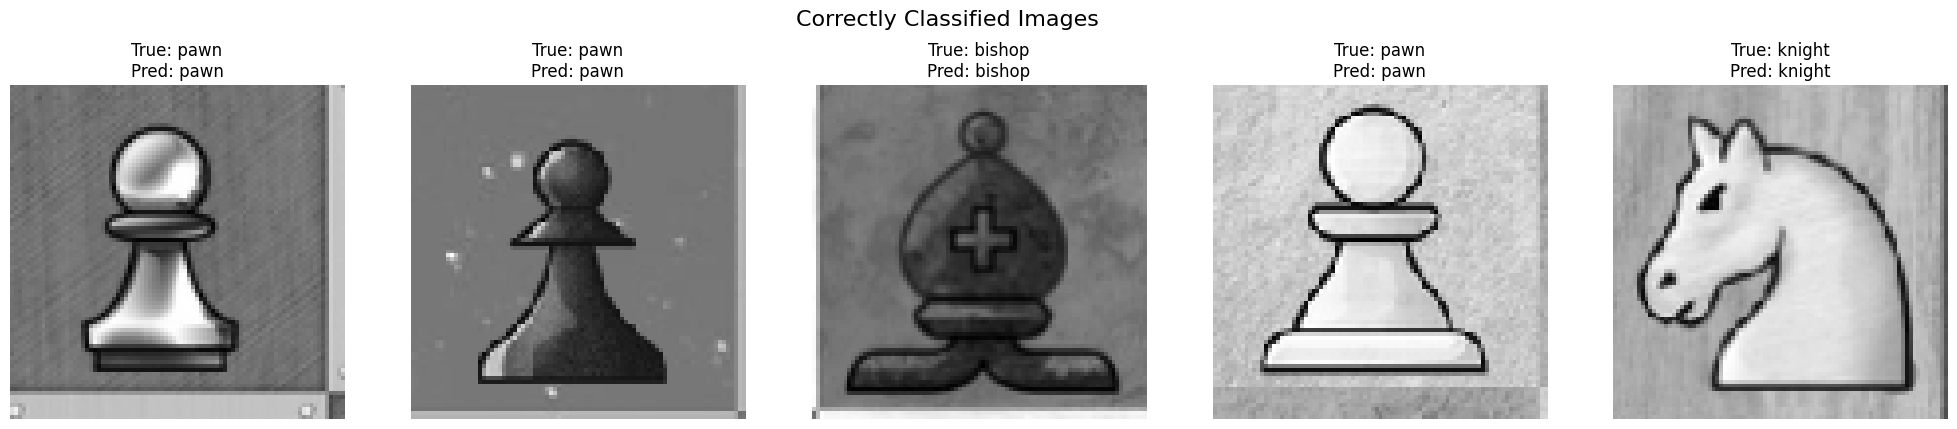

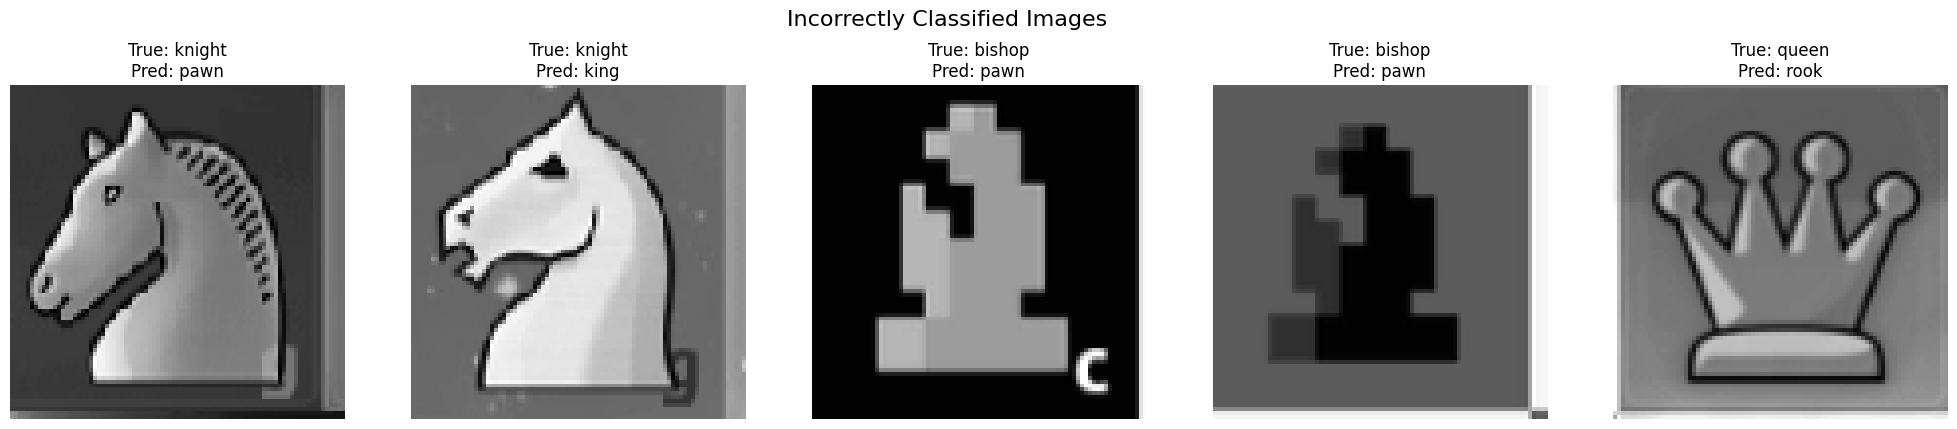

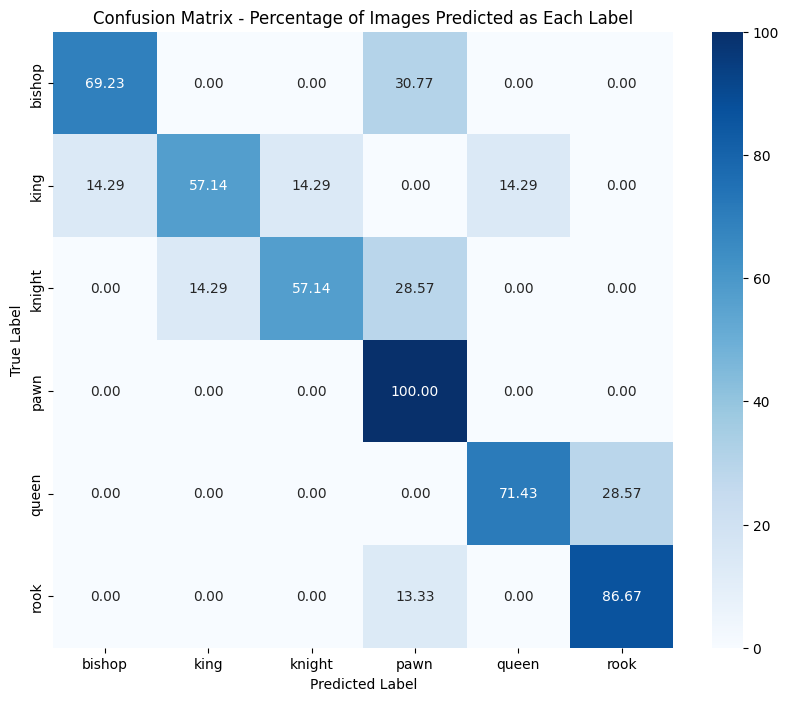

In [44]:
def canny(img):
    t_lower = 60  # Lower Threshold 
    t_upper = 200  # Upper threshold 
    aperture_size = 3  # Aperture size 
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(img_gray, t_lower, t_upper,  
                 apertureSize=aperture_size, L2gradient =True) 
    return img_canny

def get_images_canny(image_paths):
    return np.array([canny(cv2.imread(p)) for p in image_paths])

x_train_c = get_images_canny(train['image'])
y_train_c = np.array(train['label'])
x_train_c = x_train_c.reshape(x_train_c.shape[0], -1)
x_test_c = get_images_canny(test['image'])
y_test_c = np.array(test['label'])
x_test_c = x_test_c.reshape(x_test_c.shape[0], -1)
model_canny = do_svm(x_train_c, y_train_c, x_test_c, y_test_c)


[+] training model
[+] testing model
88.46153846153847


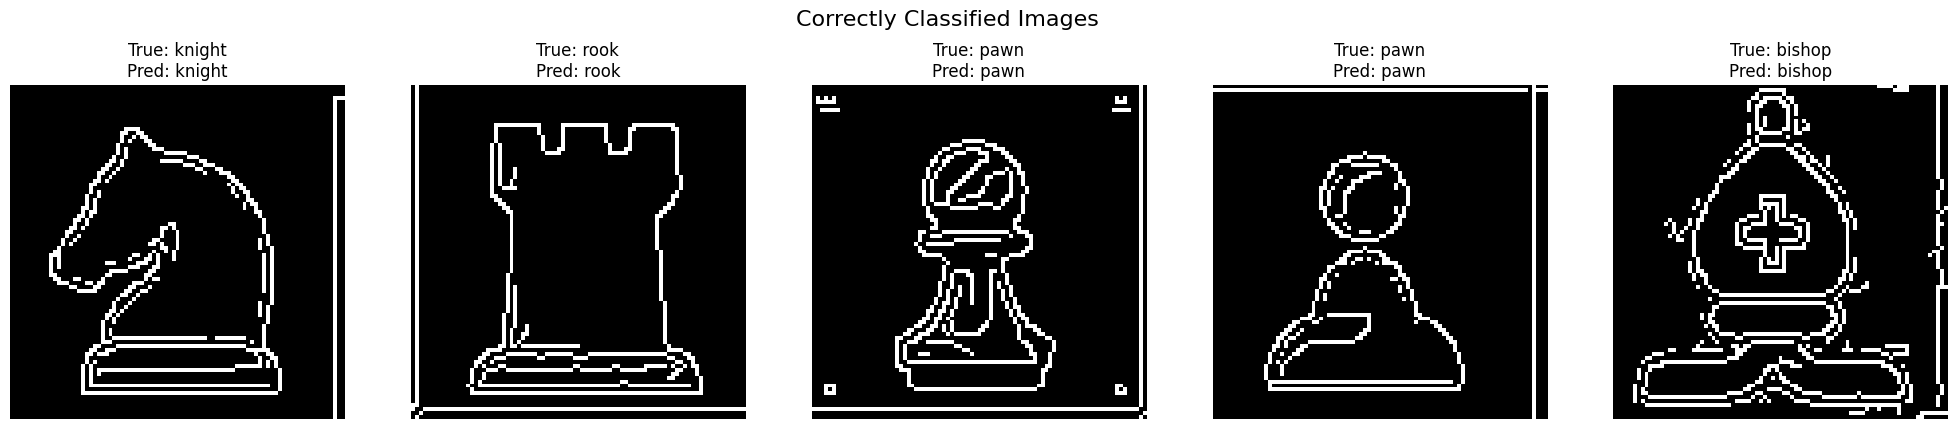

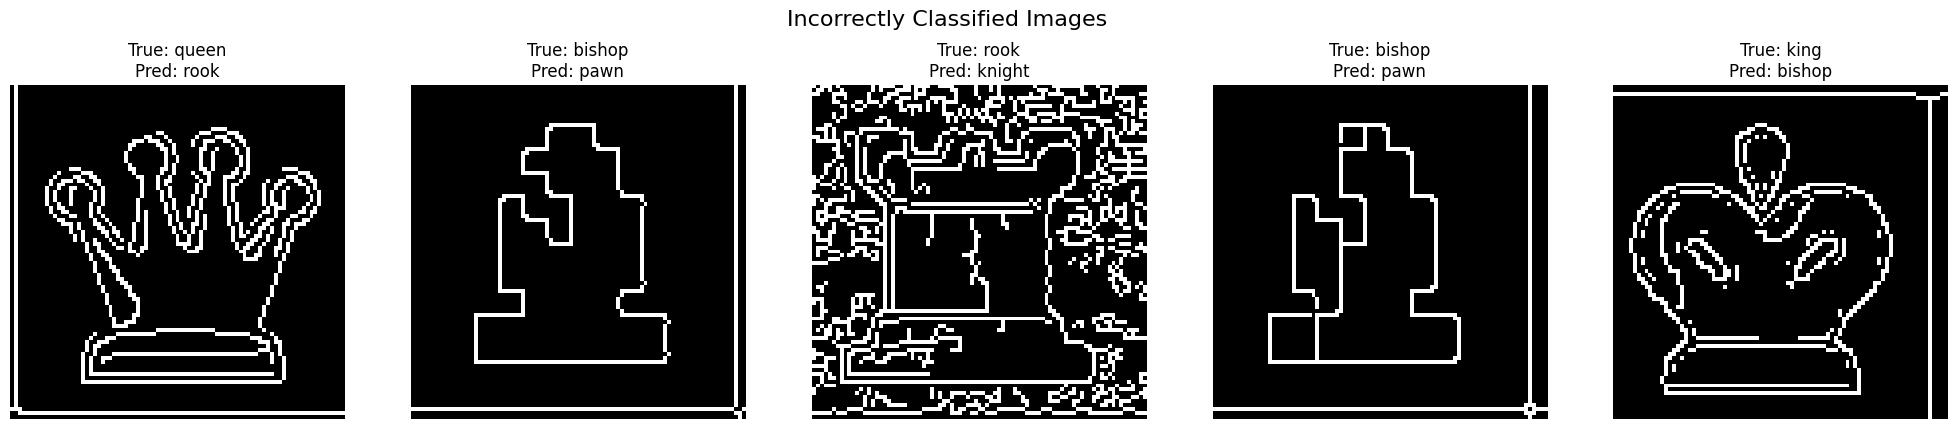

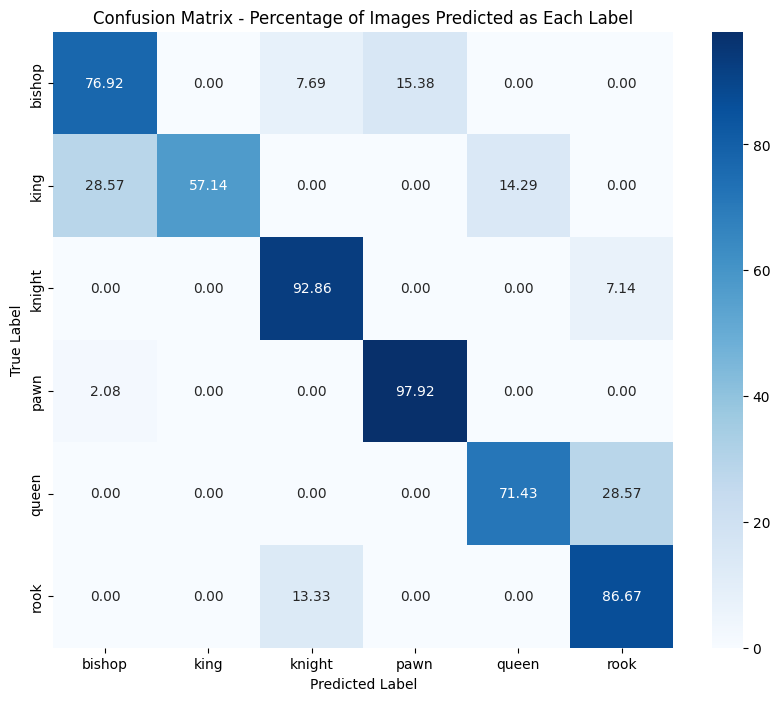

In [53]:
# Predict the labels for the test set
y_pred = model_canny.predict(x_test_c)

# Create a DataFrame to store the results
results_df = test.copy()
results_df['predicted_label'] = y_pred
results_df['correct'] = results_df['label'] == results_df['predicted_label']
labels = np.unique(y_test_c)
def canny_morph(img):
    # turn image to grayscale
    return  canny(np.array(img))

analyze_results(results_df, y_test_c, labels, morph=canny_morph)

We see that this does improve our results pretty much across the board, and by examining the confusions we see that they occur especially  when the background is noisy.  

To treat this we will try to use HOG feature extraction which will give a better representation to the meaningful objects in the image 

In [48]:
# do some HOG processing on the images so it will be better
import cv2
def hog(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    win_size = img_gray.shape
    # resize image to be multiple of 8 
    win_size = (win_size[1] - win_size[1] % 8, win_size[0] - win_size[0] % 8)
    img_gray = cv2.resize(img_gray, win_size)
    cell_size = (8, 8)
    block_size = (16, 16)
    block_stride = (8, 8)
    num_bins = 9
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)
    hog_descriptor = hog.compute(img)
    return hog_descriptor



def get_images_hog(image_paths):
    return np.array([hog(cv2.imread(p)) for p in image_paths])
    # return np.array([Image.open(p) for p in image_paths])

x_train_h = get_images_hog(train['image'])
y_train_h = np.array(train['label'])
x_train_h = x_train_h.reshape(x_train_h.shape[0], -1)
x_test_h = get_images_hog(test['image'])
y_test_h = np.array(test['label'])
x_test_h = x_test_h.reshape(x_test_h.shape[0], -1)
model_hog = do_svm(x_train_h, y_train_h, x_test_h, y_test_h)



[+] training model
[+] testing model
100.0


Seems like taking HOG representations helped us reach excellent results!


### Another method - no preprocessing
For the research purposes, let's try to use a pre trained model and fine-tune it to our dataset.
As the input to this model, we will give the original image without edge detection or other such preprocessing, and see what the model can do. 

In [62]:
# until now we got a 84%~ accuracy with the SVM learning on unmanipulated images
# let's try to use a pre-trained model with fine tuning to get better results
from transformers import ViTImageProcessor
import torch
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

In [63]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce GTX 1650 is available.


In [64]:
# train_images = get_images(train['image'])
# processor(train_images, return_tensors='pt')
import evaluate
import datasets
def vit_transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([Image.open(x) for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']
    return inputs

train_hf = datasets.Dataset.from_pandas(train)
prepared_ds_train =  train_hf.with_transform(vit_transform)
test_hf = datasets.Dataset.from_pandas(test)
prepared_ds_test =  test_hf.with_transform(vit_transform)

labels = list(set(train_hf['label']))
labels_to_ids = {label: i for i, label in enumerate(labels)}
ids_to_labels = {i: label for label, i in labels_to_ids.items()}
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([labels_to_ids[x['label']] for x in batch])
    }
metric = evaluate.load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


In [65]:
from transformers import ViTForImageClassification

# labels = train_hf.features['label'].names
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"got labels - {labels}")
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label=ids_to_labels,
    label2id=labels_to_ids
)
model.to(device)

got labels - ['knight', 'king', 'queen', 'bishop', 'pawn', 'rook']


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [66]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-chess",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

c:\Python\Python311\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [67]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds_train,
    eval_dataset=prepared_ds_test,
    tokenizer=processor,
)

In [68]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

  0%|          | 0/104 [00:00<?, ?it/s]c:\Python\Python311\Lib\site-packages\transformers\models\vit\modeling_vit.py:261: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
 10%|▉         | 10/104 [00:57<08:32,  5.45s/it]

{'loss': 1.3229, 'grad_norm': 1.5184719562530518, 'learning_rate': 0.00018076923076923077, 'epoch': 0.38}


 19%|█▉        | 20/104 [01:55<08:32,  6.11s/it]

{'loss': 0.562, 'grad_norm': 2.2871387004852295, 'learning_rate': 0.00016153846153846155, 'epoch': 0.77}


 29%|██▉       | 30/104 [02:52<06:47,  5.50s/it]

{'loss': 0.2404, 'grad_norm': 0.630206823348999, 'learning_rate': 0.0001423076923076923, 'epoch': 1.15}


 38%|███▊      | 40/104 [03:46<05:50,  5.48s/it]

{'loss': 0.2047, 'grad_norm': 3.5146443843841553, 'learning_rate': 0.0001230769230769231, 'epoch': 1.54}


 48%|████▊     | 50/104 [04:41<05:00,  5.57s/it]

{'loss': 0.1536, 'grad_norm': 0.33856797218322754, 'learning_rate': 0.00010384615384615386, 'epoch': 1.92}


 58%|█████▊    | 60/104 [05:36<04:03,  5.53s/it]

{'loss': 0.1015, 'grad_norm': 0.7861164212226868, 'learning_rate': 8.461538461538461e-05, 'epoch': 2.31}


 67%|██████▋   | 70/104 [06:32<03:10,  5.60s/it]

{'loss': 0.0909, 'grad_norm': 0.26161429286003113, 'learning_rate': 6.538461538461539e-05, 'epoch': 2.69}


 77%|███████▋  | 80/104 [07:27<02:09,  5.41s/it]

{'loss': 0.0846, 'grad_norm': 0.26583749055862427, 'learning_rate': 4.615384615384616e-05, 'epoch': 3.08}


 87%|████████▋ | 90/104 [08:22<01:17,  5.50s/it]

{'loss': 0.0761, 'grad_norm': 0.2463161200284958, 'learning_rate': 2.6923076923076923e-05, 'epoch': 3.46}


 96%|█████████▌| 100/104 [09:18<00:22,  5.58s/it]

{'loss': 0.0664, 'grad_norm': 0.21835936605930328, 'learning_rate': 7.692307692307694e-06, 'epoch': 3.85}


                                                 
 96%|█████████▌| 100/104 [09:32<00:22,  5.58s/it]

{'eval_loss': 0.10267961770296097, 'eval_accuracy': 0.9807692307692307, 'eval_runtime': 14.2824, 'eval_samples_per_second': 7.282, 'eval_steps_per_second': 0.91, 'epoch': 3.85}


100%|██████████| 104/104 [10:05<00:00,  5.82s/it]


{'train_runtime': 605.312, 'train_samples_per_second': 2.729, 'train_steps_per_second': 0.172, 'train_loss': 0.2815812831887832, 'epoch': 4.0}
***** train metrics *****
  epoch                    =         4.0
  total_flos               = 119229179GF
  train_loss               =      0.2816
  train_runtime            =  0:10:05.31
  train_samples_per_second =       2.729
  train_steps_per_second   =       0.172


In [69]:
metrics = trainer.evaluate(prepared_ds_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

100%|██████████| 13/13 [00:11<00:00,  1.15it/s]

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9808
  eval_loss               =     0.1027
  eval_runtime            = 0:00:12.39
  eval_samples_per_second =      8.391
  eval_steps_per_second   =      1.049


100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


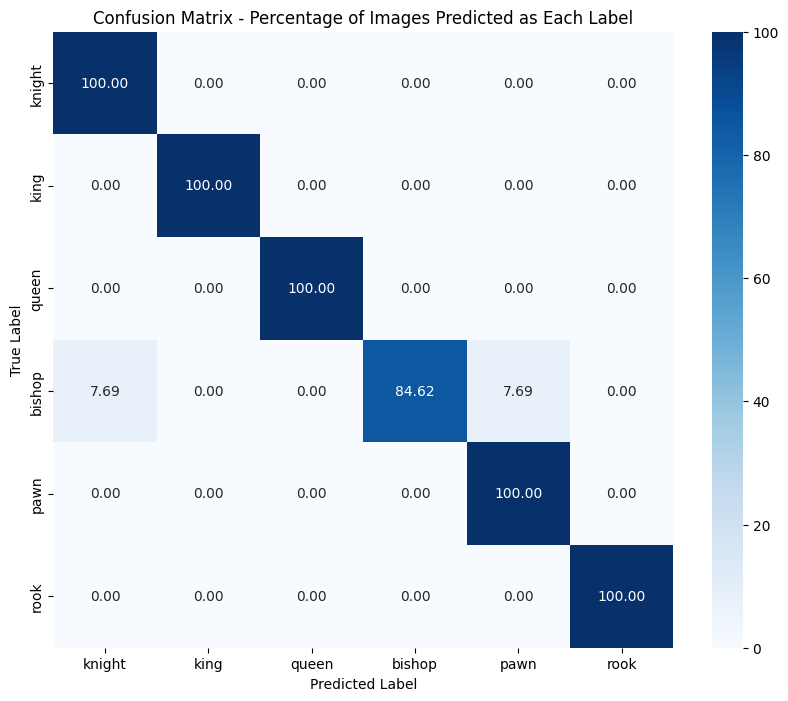

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Predict the labels for the test set
predictions = trainer.predict(prepared_ds_test)
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Convert confusion matrix to percentages
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Create a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix_percentage, index=labels, columns=labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title('Confusion Matrix - Percentage of Images Predicted as Each Label')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

We got a decent accuracy of 97%, and this is without any pre-processing of our image!
We also note that the main parsing mistakes were in the bishop calss - so by strainghening the bishop representation it might be possible to eliminate this kind of mistake. 
Let's try adding more bishop images from the
We can see that this type of model is stronger in our case, and for this assignment we will use it.


In [73]:
data_dir = "pices_db/data_icons"


bishop_images = get_images_for_subpath(data_dir, "bishop_improved") # added more bishop images
knight_images = get_images_for_subpath(data_dir, "knight")
pawn_images = get_images_for_subpath(data_dir, "pawn")
king_images = get_images_for_subpath(data_dir, "king")
queen_images = get_images_for_subpath(data_dir, "queen")
rook_images = get_images_for_subpath(data_dir, "rook")

# create a dataframe with the images and their labels
df = pd.DataFrame({'image': np.concatenate([bishop_images, knight_images, pawn_images, king_images, queen_images, rook_images]),
                   'label': ['bishop']*len(bishop_images) + ['knight']*len(knight_images) + ['pawn']*len(pawn_images) + ['king']*len(king_images) + ['queen']*len(queen_images) + ['rook']*len(rook_images)})


train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

train_hf = datasets.Dataset.from_pandas(train)
prepared_ds_train =  train_hf.with_transform(vit_transform)
test_hf = datasets.Dataset.from_pandas(test)
prepared_ds_test =  test_hf.with_transform(vit_transform)


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds_train,
    eval_dataset=prepared_ds_test,
    tokenizer=processor,
)

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

  9%|▉         | 10/108 [00:53<08:43,  5.34s/it]

{'loss': 0.0888, 'grad_norm': 0.2065919190645218, 'learning_rate': 0.0001814814814814815, 'epoch': 0.37}


 19%|█▊        | 20/108 [01:46<07:50,  5.35s/it]

{'loss': 0.087, 'grad_norm': 0.2092103362083435, 'learning_rate': 0.00016296296296296295, 'epoch': 0.74}


 28%|██▊       | 30/108 [02:39<06:49,  5.25s/it]

{'loss': 0.0812, 'grad_norm': 7.250420093536377, 'learning_rate': 0.00014444444444444444, 'epoch': 1.11}


 37%|███▋      | 40/108 [03:33<06:04,  5.36s/it]

{'loss': 0.0403, 'grad_norm': 0.14786793291568756, 'learning_rate': 0.00012592592592592592, 'epoch': 1.48}


 46%|████▋     | 50/108 [04:27<05:15,  5.44s/it]

{'loss': 0.0466, 'grad_norm': 0.08849246054887772, 'learning_rate': 0.00010740740740740742, 'epoch': 1.85}


 56%|█████▌    | 60/108 [05:22<04:26,  5.55s/it]

{'loss': 0.0237, 'grad_norm': 0.07661386579275131, 'learning_rate': 8.888888888888889e-05, 'epoch': 2.22}


 65%|██████▍   | 70/108 [06:18<03:31,  5.55s/it]

{'loss': 0.022, 'grad_norm': 0.06801101565361023, 'learning_rate': 7.037037037037038e-05, 'epoch': 2.59}


 74%|███████▍  | 80/108 [07:14<02:36,  5.59s/it]

{'loss': 0.0209, 'grad_norm': 0.07590053975582123, 'learning_rate': 5.185185185185185e-05, 'epoch': 2.96}


 83%|████████▎ | 90/108 [08:09<01:39,  5.52s/it]

{'loss': 0.0193, 'grad_norm': 0.0648208037018776, 'learning_rate': 3.3333333333333335e-05, 'epoch': 3.33}


 93%|█████████▎| 100/108 [09:03<00:43,  5.42s/it]

{'loss': 0.0174, 'grad_norm': 0.0732017382979393, 'learning_rate': 1.4814814814814815e-05, 'epoch': 3.7}


                                                 
 93%|█████████▎| 100/108 [09:18<00:43,  5.42s/it]

{'eval_loss': 0.03497293218970299, 'eval_accuracy': 0.9907407407407407, 'eval_runtime': 15.0353, 'eval_samples_per_second': 7.183, 'eval_steps_per_second': 0.931, 'epoch': 3.7}


100%|██████████| 108/108 [10:15<00:00,  5.70s/it]


{'train_runtime': 615.4705, 'train_samples_per_second': 2.795, 'train_steps_per_second': 0.175, 'train_loss': 0.04274964056633137, 'epoch': 4.0}
***** train metrics *****
  epoch                    =         4.0
  total_flos               = 124136917GF
  train_loss               =      0.0427
  train_runtime            =  0:10:15.47
  train_samples_per_second =       2.795
  train_steps_per_second   =       0.175


In [74]:
metrics = trainer.evaluate(prepared_ds_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

100%|██████████| 14/14 [00:12<00:00,  1.13it/s]

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9907
  eval_loss               =      0.035
  eval_runtime            = 0:00:14.28
  eval_samples_per_second =      7.559
  eval_steps_per_second   =       0.98


100%|██████████| 14/14 [00:11<00:00,  1.19it/s]


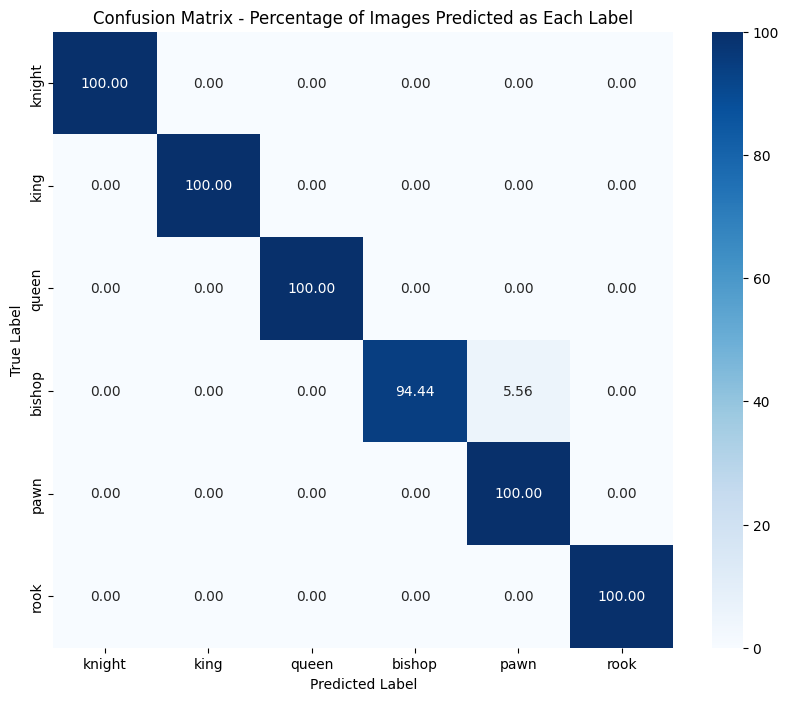

In [75]:

# Predict the labels for the test set
predictions = trainer.predict(prepared_ds_test)
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Convert confusion matrix to percentages
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Create a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix_percentage, index=labels, columns=labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title('Confusion Matrix - Percentage of Images Predicted as Each Label')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

We see a slight improvement, but it might be due to the fact that some of our new bishop icons are not exactly in the same format as the rrest of the images, so they are  "easy" to classify.
Any way, this result will be good enough for our case and so we will use it.

In [76]:
# now that we have tested and trained the model, we need to use it for running the predictionima
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# test_image_6_7.png should be a pawn 
inputs = processor([np.array(Image.open('analyzed/test_image_6_7.png'), dtype=np.float16)], return_tensors='pt').to(device) 
print(inputs)
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_idx = logits.argmax(-1).item()
predicted_label = model.config.id2label[predicted_class_idx]
print(predicted_class_idx, predicted_label)

{'pixel_values': tensor([[[[-0.1294, -0.1294, -0.1294,  ..., -0.5843, -0.6549, -0.6549],
          [-0.1294, -0.1294, -0.1294,  ..., -0.5843, -0.6549, -0.6549],
          [-0.1216, -0.1216, -0.1216,  ..., -0.5843, -0.6549, -0.6549],
          ...,
          [ 0.2627,  0.2627,  0.2627,  ..., -0.5608, -0.6863, -0.6863],
          [ 0.3647,  0.3647,  0.3647,  ..., -0.5529, -0.6941, -0.6941],
          [ 0.3647,  0.3647,  0.3647,  ..., -0.5529, -0.6941, -0.6941]],

         [[ 0.1373,  0.1373,  0.1373,  ..., -0.5922, -0.7020, -0.7020],
          [ 0.1373,  0.1373,  0.1373,  ..., -0.5922, -0.7020, -0.7020],
          [ 0.1451,  0.1451,  0.1451,  ..., -0.5922, -0.7020, -0.7020],
          ...,
          [ 0.4196,  0.4196,  0.4196,  ..., -0.5686, -0.7176, -0.7176],
          [ 0.4980,  0.4980,  0.4980,  ..., -0.5608, -0.7255, -0.7255],
          [ 0.4980,  0.4980,  0.4980,  ..., -0.5608, -0.7255, -0.7255]],

         [[-0.3804, -0.3804, -0.3804,  ..., -0.6471, -0.6863, -0.6863],
          [-0

In [77]:
# Define a function to use later in the identification process
def identify_chess_piece(model, images):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # test_image_6_7.png should be a pawn 
    inputs = processor(images, return_tensors='pt').to(device) 
    # print(inputs)
    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_class_idx = logits.argmax(-1).item()
    predicted_label = model.config.id2label[predicted_class_idx]
    return predicted_label


## Conclusion
We see that if we are willing to use prepcoressing, we can achive very good results with a relativly light-weighted model (SVM).
If we find the preprocessing to expensive or problematic to implement in real-world scenarios, we can instead use a find-tuned version of a pre-trained classification model.
